## 28x28

In [95]:

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

n_epochs = 1   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 200    # Size of the train dataset
n_test = 120     # Size of the test dataset
n_batches = 1     # Size of the batches

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]




In [96]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

n_qubits = 4

dev = qml.device("default.qubit", wires=n_qubits)
# Random circuit parameters
random_weights = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))


@qml.qnode(dev, interface='tf')
def qrandnode(inputs):
    inputs *= np.pi
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # Random quantum circuit
    RandomLayers(random_weights, wires=list(range(n_qubits)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


@qml.qnode(dev, interface='tf')
def qnotnode(inputs):
    inputs *= np.pi
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # Filter from arxiv.org/abs/2308.14930
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 3])

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


@qml.qnode(dev, interface='tf')
def qhadrandnode(inputs):
    inputs *= np.pi
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')


    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 3])
    qml.Hadamard(wires=[1])
    qml.Hadamard(wires=[2])
    qml.ctrl(qml.Hadamard, control=1)(wires=2)
    qml.ctrl(qml.Hadamard, control=2)(wires=0)
    qml.ctrl(qml.Hadamard, control=1)(wires=2)
    qml.ctrl(qml.Hadamard, control=0)(wires=3)
    qml.Hadamard(wires=[1])
    qml.Hadamard(wires=[0])
    qml.Hadamard(wires=[3])

    
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


qrandlayer = qml.qnn.KerasLayer(qrandnode, {}, output_dim=[28,28,n_qubits])

qrandlayer.trainable = False

qnotlayer = qml.qnn.KerasLayer(qnotnode, {}, output_dim=[28,28,n_qubits])

qnotlayer.trainable = False

qhadrandlayer = qml.qnn.KerasLayer(qhadrandnode, {}, output_dim=[28,28,n_qubits])

qhadrandlayer.trainable = False

## Unprocessed

Example of base subject

Yellow is black and dark blue is white

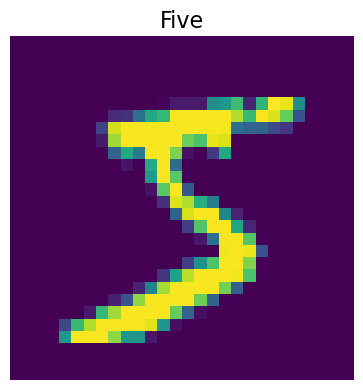

In [97]:
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(train_images[0])
ax.set_title('Five', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## Random Layer (Original QMOD)

Expands subject into two unique configurations

The first includes the core shape with inverted values

and the next configuration values are all skewed towards white and edges are highlighted in neutral

There is one core shape channel and 3 identical neutral edge channels

/opt/conda/envs/QML-QPF/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


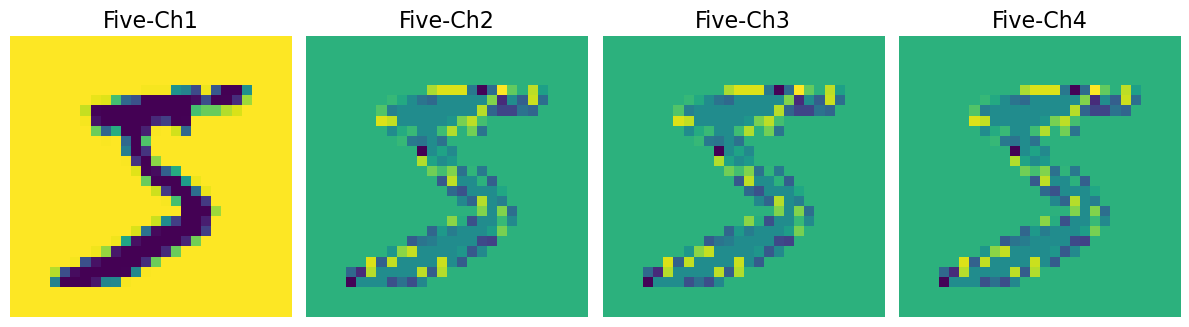

In [98]:
fin  = qrandlayer(train_images[0])

image_titles = ['Five-Ch1', 'Five-Ch2', 'Five-Ch3','Five-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(fin[:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## QNOT Layer

Expands subject into two unique configurations

The first includes the core shape with inverted values

and the next configuration values are all skewed towards neutral and edge features are highlighted with extrema values

there are an equal number of core shape and extreme value edge channels

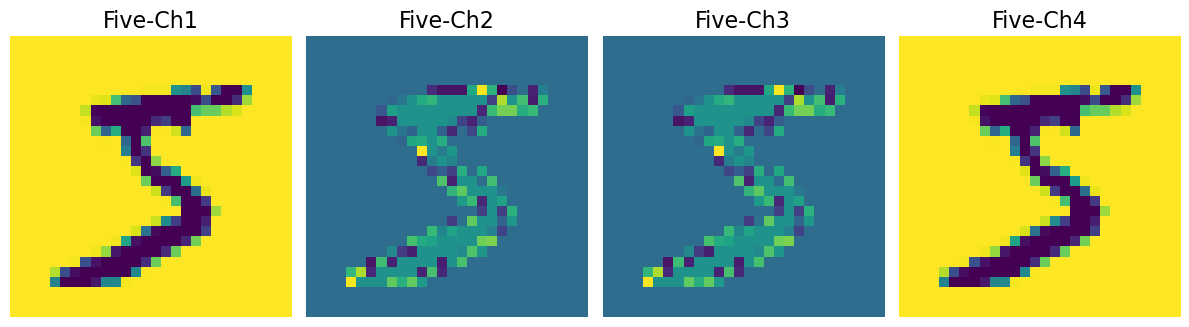

In [99]:
image_titles = ['Five-Ch1', 'Five-Ch2', 'Five-Ch3','Five-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(qnotlayer(train_images[0])[:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## QHADRAND

Evaluating the affects on the subject from the previous layers it seems highlighting more features and avoiding skewing the entire subject improved training and evaluation

Following this trend the experimental configuration below keeps the two copies of the inverted core shape and adds a robust edge and a soft edge chanel 

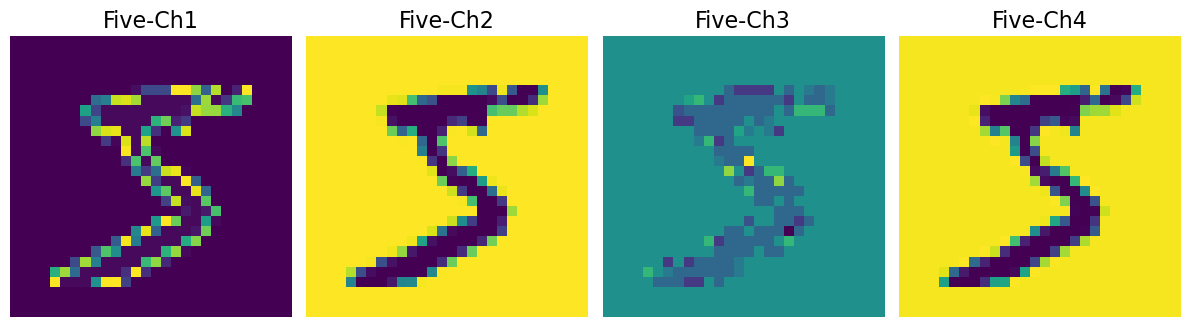

In [100]:
image_titles = ['Five-Ch1', 'Five-Ch2', 'Five-Ch3','Five-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(qhadrandlayer(train_images[0])[:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Results

there is a slight improvement between the qrand(qmod) model and the qnot model

The qhadrand model has a small improvement in training speed and an increased evaluation accuracy

It also has a smoother ascent and steadier accuracy



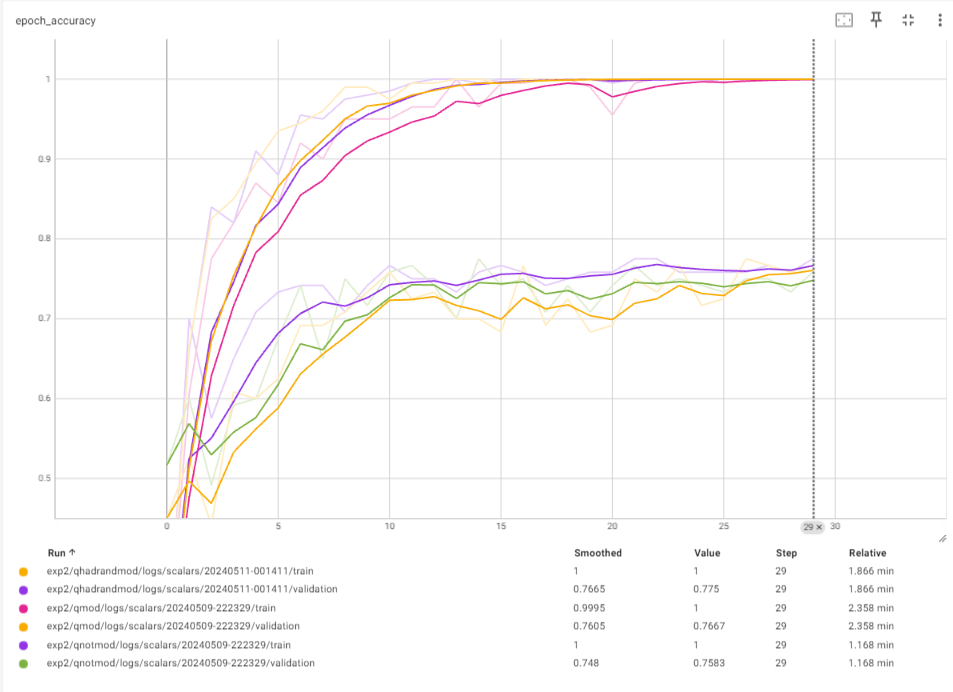